<a href="https://colab.research.google.com/github/nascimento-luciano/Artificial-Intelligence/blob/master/Copy_of_Analise_COVID_19_Mercosul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
#---------------------------------Etapa 1--------------------------------------
#Importanto bibliotecas

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#import geopandas as gpd -----> Verificar porque não carrega a biblioteca
import plotly.express as px
import plotly.graph_objects as go

In [210]:
#Importação da biblioteca geopandas via instalação no Colab
!pip install geopandas

In [211]:
#---------------------------------Etapa 2--------------------------------------
#Importando Arquivo CSV
#Dados não "Oficiais"
covid_cases = pd.read_csv('worldometer_coronavirus_daily_data.csv')
covid_vaxxs = pd.read_csv('country_vaccinations.csv')
df = pd.read_csv('covid_19_data.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sub=pd.read_csv('submission.csv')

#submission=pd.read_csv('submission.csv')
#confirmed_df = pd.read_csv('time_series_covid_19_confirmed.csv')
#train['Date'] = pd.to_datetime(train['Date'])
#test['Date'] = pd.to_datetime(test['Date'])


In [212]:
#---------------------------------Etapa 3--------------------------------------
#Vamos marcar o datase e usar como amostra os países do Mercosul: Brazil, Argentina, Paraguay e Uruguay

def fix_country_name(country):
    name_dict = {
        'BRA': 'Brazil',
        'ARG': 'Argentina',
        'PRY': 'Paraguay',
        'URY': 'Uruguay'
     }
    try:
      return name_dict[country]
    except KeyError:
      return country

covid_cases.country = covid_cases.country.apply(fix_country_name)

In [213]:
#---------------------------------Etapa 4--------------------------------------
#Vamos observar esses 4 países
countries_of_interest = ["Brazil", "Argentina", "Paraguay", "Uruguay"]

#Vamos começar a limpar os dados filtrando-os para o subconjunto de países que desejamos.
covid_cases_subset = covid_cases[covid_cases.country.isin (countries_of_interest)]
covid_vaxxs_subset = covid_vaxxs[covid_vaxxs.country.isin (countries_of_interest)]

In [214]:
#---------------------------------Etapa 5--------------------------------------
#Unindo os databases usando as datas e países
   
merged_data = pd.merge_ordered(covid_cases_subset, covid_vaxxs_subset, \
                               left_on=['date', 'country'], \
                               right_on=['date', 'country'])

#Remove as colunas desnecessárias
merged_data.drop(columns=['iso_code', 'source_name', 'source_website', 'vaccines',\
                           'daily_vaccinations_per_million', 'daily_vaccinations_raw'], inplace=True)

In [215]:
#---------------------------------Etapa 6--------------------------------------
#Vamos lidar com os NaNs
merged_data.fillna({'total_vaccinations':0, 'people_vaccinated':0, 'people_fully_vaccinated':0,\
                 'daily_vaccinations':0,'total_vaccinations_per_hundred':0,\
                 'people_vaccinated_per_hundred':0 ,'people_fully_vaccinated_per_hundred':0}\
                 ,inplace=True)

covid_data = merged_data.dropna(how='any', subset=['cumulative_total_cases'])

In [216]:
#---------------------------------Etapa 7--------------------------------------
#Vamos também definir o índice para a data
covid_data.set_index('date', inplace=True)

In [217]:
#Vamos mudar o índice para um objeto datetime agora
covid_data.index = pd.to_datetime(covid_data.index, errors='coerce', infer_datetime_format=True)

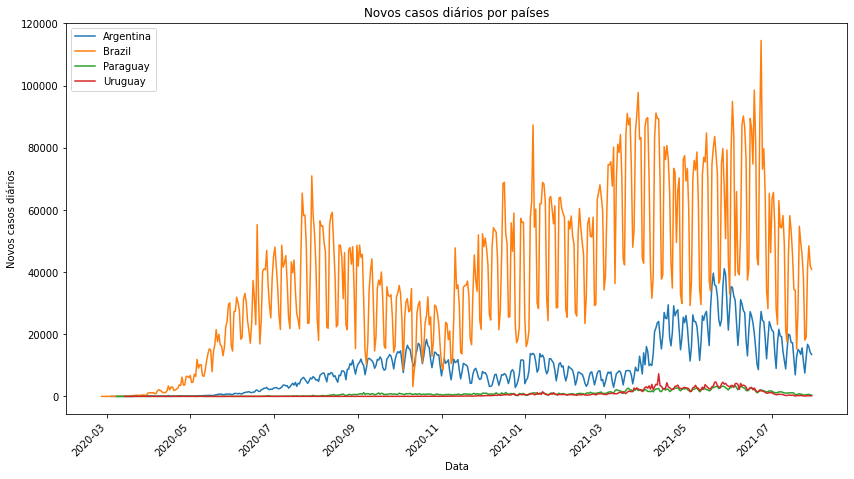

In [218]:
#---------------------------------Etapa 8--------------------------------------
#Taxas de infecção nos países do Mercosul
plt.figure(figsize=(14, 8))
covid_data.groupby('country').daily_new_cases.plot(legend=True,rot=45)

plt.ylabel('Novos casos diários')
plt.xlabel('Data')
plt.title('Novos casos diários por países');

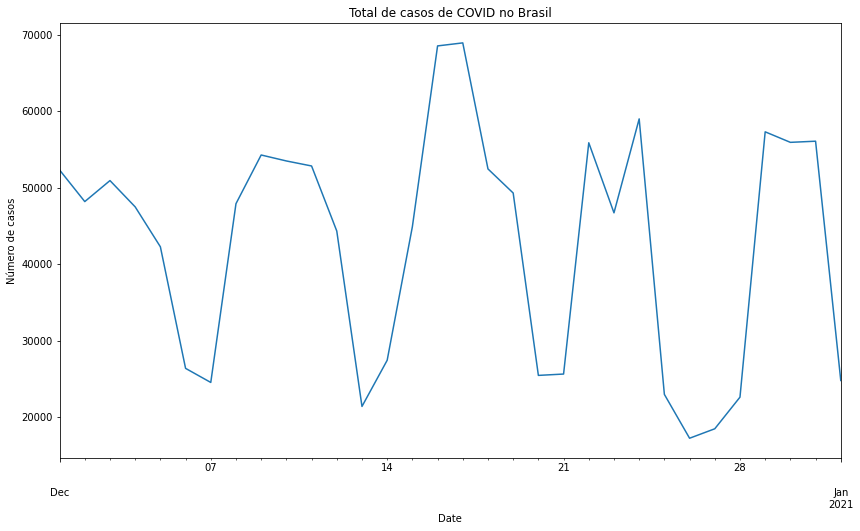

In [219]:
#---------------------------------Etapa 9--------------------------------------
#Agora vamos ampliar o gráfico e observar o padrão. [17/01/2021 - Refere-se a primeira pessoa vacinada no Brasil]
week_intervals = ['17/01/2021','24/01/2021','31/01/2021','07/02/2021']

plt.figure(figsize=(14, 8))
covid_data[covid_data.country == 'Brazil'] \
  .loc['12/1/2020':'1/1/2021'].daily_new_cases.plot()

{plt.axvline(d, color='k', linestyle='dashed', linewidth=1) for d in week_intervals}

plt.ylabel('Número de casos')
plt.xlabel('Date')
plt.title('Total de casos de COVID no Brasil');

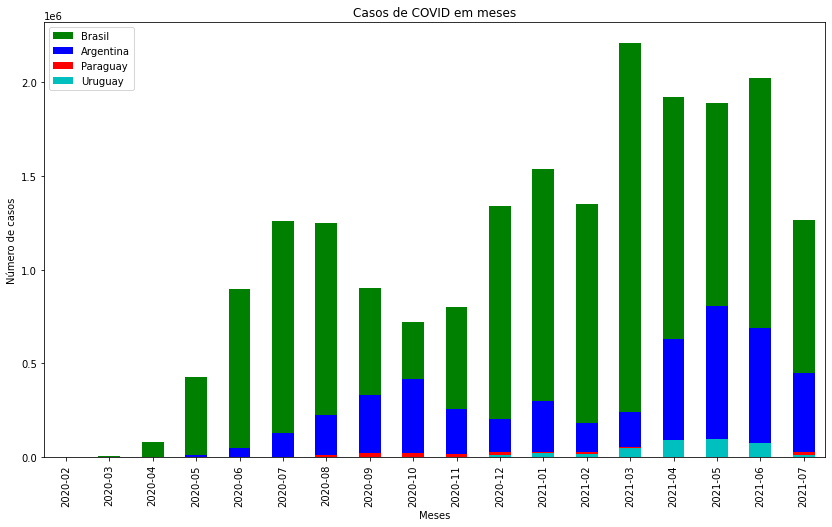

In [220]:
#---------------------------------Etapa 10--------------------------------------
#A época do ano é importante para infecções?
BRA_infections = covid_data[covid_data.country == 'Brazil']
ARG_infections = covid_data[covid_data.country == 'Argentina']
PRY_infections = covid_data[covid_data.country == 'Paraguay']
URY_infections = covid_data[covid_data.country == 'Uruguay']

plt.figure(figsize=(14, 8))
BRA_infections['daily_new_cases']\
  .groupby(BRA_infections.index.to_period('M'))\
  .sum().plot(kind='bar', legend=False, color='g')

ARG_infections['daily_new_cases']\
 .groupby(ARG_infections.index.to_period('M'))\
 .sum().plot(kind='bar', legend=False, color='b')

PRY_infections['daily_new_cases']\
 .groupby(ARG_infections.index.to_period('M'))\
 .sum().plot(kind='bar', legend=False, color='r')

URY_infections['daily_new_cases']\
 .groupby(ARG_infections.index.to_period('M'))\
 .sum().plot(kind='bar', legend=False, color='c')

plt.legend(['Brasil', 'Argentina', 'Paraguay', 'Uruguay'])
plt.ylabel('Número de casos')
plt.xlabel('Meses')
plt.title('Casos de COVID em meses');

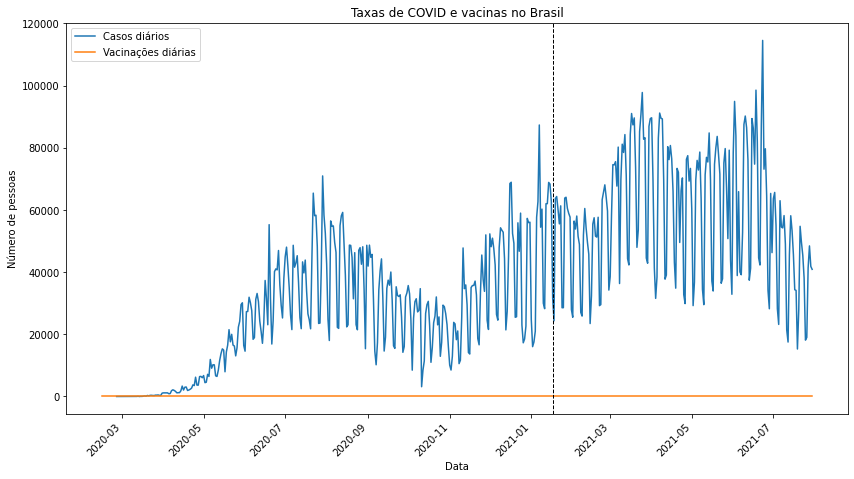

In [221]:
#---------------------------------Etapa 11--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(14, 8))
covid_data[covid_data.country == 'Brazil'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Brazil'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina  -----> Mônica Calazans (Primeiro Vacinado)
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Brasil');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil
#https://ourworldindata.org/coronavirus/country/brazil

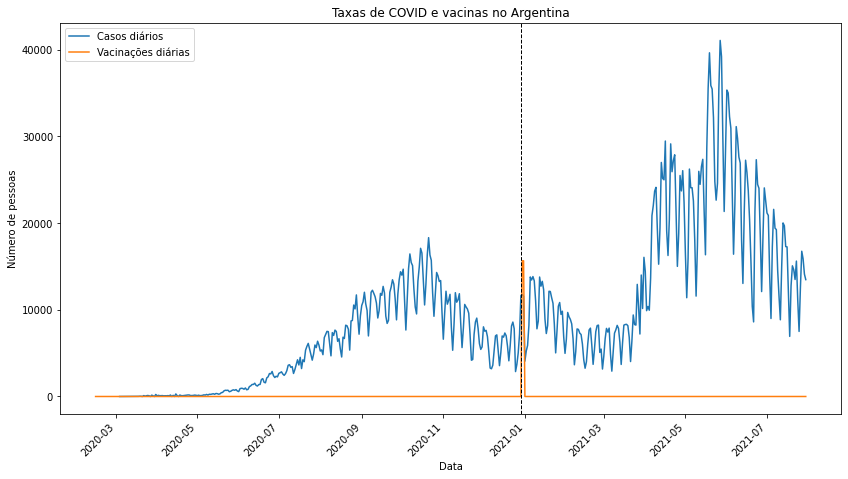

In [222]:
#---------------------------------Etapa 12--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(14, 8))
covid_data[covid_data.country == 'Argentina'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Argentina'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina -----> Flavia Loiacono (Primeiro Vacinado)
plt.axvline('29/12/2020', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Argentina');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Argentina
#https://ourworldindata.org/coronavirus/country/argentina

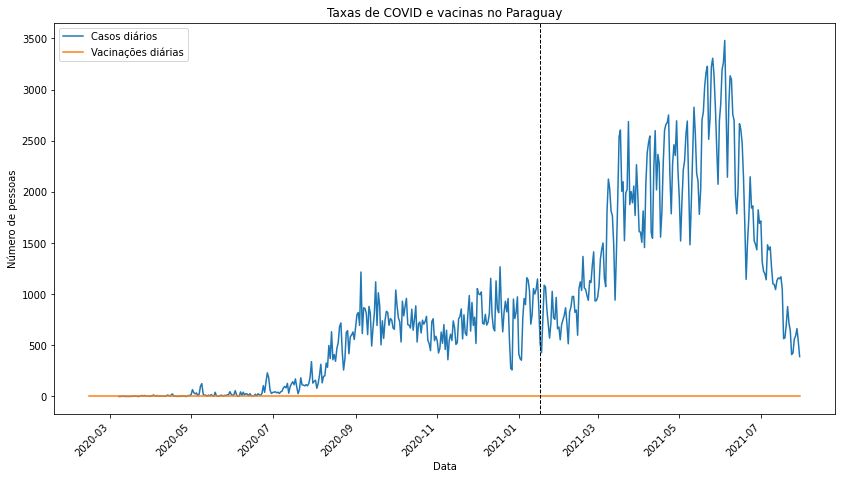

In [223]:
#---------------------------------Etapa 13--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(14, 8))
covid_data[covid_data.country == 'Paraguay'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Paraguay'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Paraguay');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Paraguay
#https://ourworldindata.org/coronavirus/country/paraguay

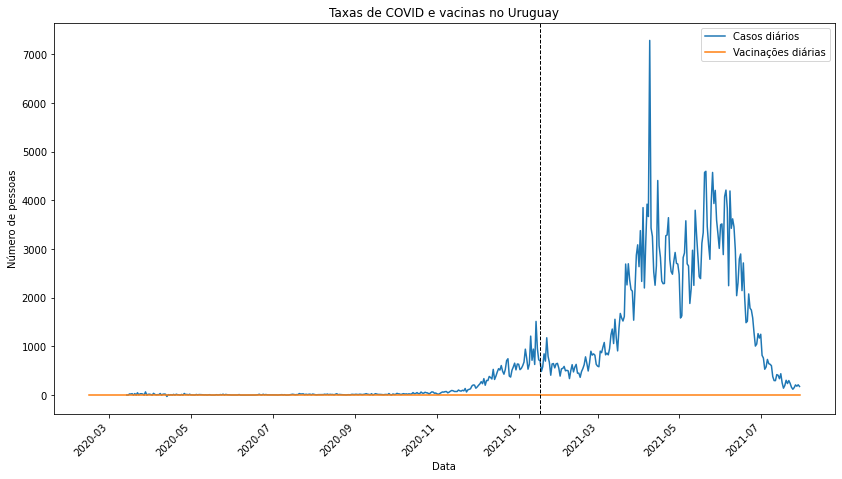

In [224]:
#---------------------------------Etapa 14--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(14, 8))
covid_data[covid_data.country == 'Uruguay'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Uruguay'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Uruguay');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Uruguay
#https://ourworldindata.org/coronavirus/country/uruguay

--------------------------Fim do Código---------------------------------------

2ª Parte - Plotagem do Modelo de Predição da Covid no Brasil

In [225]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
#import squarify
import plotly.offline as py
import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [226]:
#Importação da biblioteca squarify via instalação no Colab
!pip install squarify
#!pip install plotly.offline
!pip install plotly_express

In [227]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


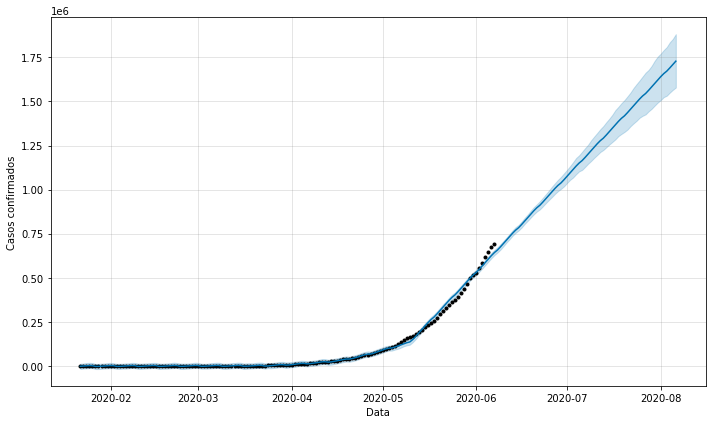

In [232]:
#Predição usando Prophet Model 
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
k = df1[df1['Country/Region']=='Brazil'].loc[:,'1/22/20':]
brazil_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = brazil_confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=60)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(60)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Data',ylabel='Casos confirmados')

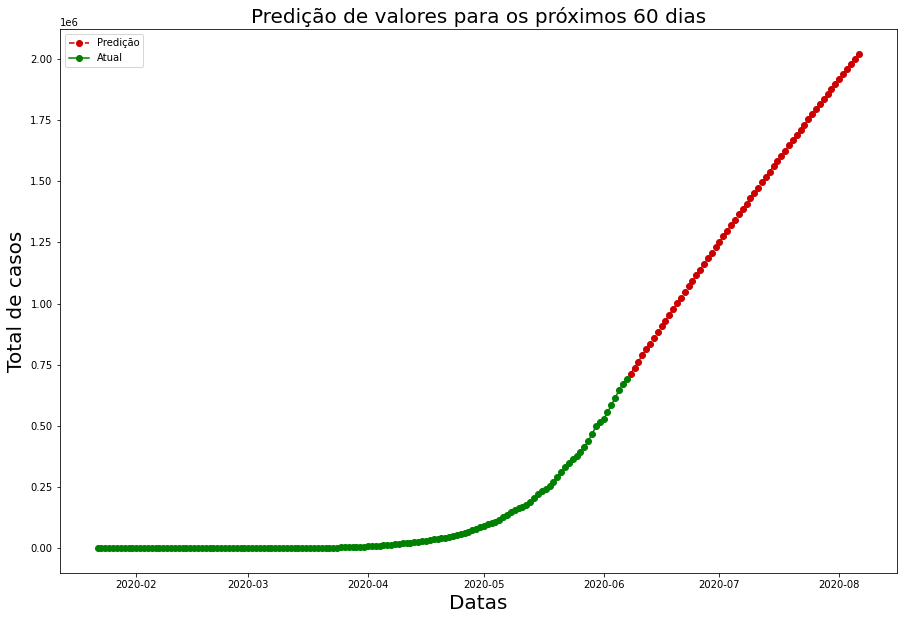

In [231]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 60)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(60):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Datas",fontsize = 20)
plt.ylabel('Total de casos',fontsize = 20)
plt.title("Predição de valores para os próximos 60 dias" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#cc0000',label = 'Predição');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'green',label = 'Atual');
plt.legend();


In [280]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
